In [283]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d

In [284]:
plt.rcParams['figure.figsize'] = [10,5]

In [285]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [286]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803


# Geometry Definition
Cell

In [287]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 24
sy = 15

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

Bragg Reflector


In [288]:
#materials refractive indexes
Dn = 1.9
n_1 = 1.45
n_2 = n_1 + Dn

print("#Dielectric constant eps_1: ", n_1*n_1)
print("#Dielectric constant eps_2: ", n_2*n_2)
print("#Dielectric constant Delta_eps: ", n_1*n_1-n_2*n_2)
print("#Dielectric constant Ratio: ", (n_1*n_1-n_2*n_2)/(n_1*n_1))


#Si 3.5
#SiO2 1.45

#Bragg params
#central cavity (if present)
width_cavity = 1

#Layer thickness
width_1 = 0.5
width_2 = 0.5

#Half the number of layers
N_layers = 12

#The x position of the BR boundaries
bragg_width = (width_2 + width_1)*N_layers


#Dielectric constant eps_1:  2.1025
#Dielectric constant eps_2:  11.222499999999998
#Dielectric constant Delta_eps:  -9.119999999999997
#Dielectric constant Ratio:  -4.337693222354339


Source

In [289]:
#Soure parameters
source_x = -bragg_width/2 - 4
source_y = 0

source_width = 11

#note: df is not really the frequency sigma
f_central = 0.22
df = 0.28


print("#Source pulse frequency: fcent= ", f_central*freq_unit*1e-12, " THz, df= ",df*freq_unit*1e-12, " THz" )
print("#Source vacuum wavelength: lambda = ",  c/(f_central*freq_unit)*1e+6, "um, dlambda = ",c/(df*freq_unit)*1e+6,"um")
print("#Source material 1 wavelength: lambda = ",  (c/n_1)/(f_central*freq_unit)*1e+6, "um, dlambda = ", (c/n_1)/(df*freq_unit)*1e+6,"um")
print("#Source material 2 wavelength: lambda = ",  (c/n_2)/(f_central*freq_unit)*1e+6, "um, dlambda = ", (c/n_2)/(df*freq_unit)*1e+6,"um")

#Source pulse frequency: fcent=  65.95434076  THz, df=  83.94188824000001  THz
#Source vacuum wavelength: lambda =  4.545454545454546 um, dlambda =  3.5714285714285707 um
#Source material 1 wavelength: lambda =  3.1347962382445145 um, dlambda =  2.463054187192118 um
#Source material 2 wavelength: lambda =  1.35685210312076 um, dlambda =  1.0660980810234542 um


Monitors

In [290]:

#Monitor parameters
#input
mon_1_x = -bragg_width/2 - 2
mon_1_width = sy - 2*pml_thickness

#output
mon_2_x = bragg_width/2 + 2
mon_2_h = sy - 2*pml_thickness

#number of sampling points in frequency for fourier transform of fields accumulated
N_freq = 300

#central frequency
f_mon_central = f_central
#width of sampled frequency band
df_mon = df



#Point for simulation termination condition
check_pt = mp.Vector3(0, bragg_width/2 + 0.5)


# Normalization Run
No DBR

-----------
Initializing structure...
time for choose_chunkdivision = 0.000161886 s
Working in 2D dimensions.
Computational cell is 24 x 15 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
time for set_epsilon = 0.301356 s
-----------
field decay(t = 50.025000000000006): 0.01763974821082624 / 0.01763974821082624 = 1.0
on time step 3049 (time=76.225), 0.001312 s/step
field decay(t = 100.05000000000001): 4.506505253539218e-11 / 0.01763974821082624 = 2.554744659435326e-09
Normalizing field data...
run 0 finished at t = 100.05000000000001 (4002 timesteps)
Generating MP4...


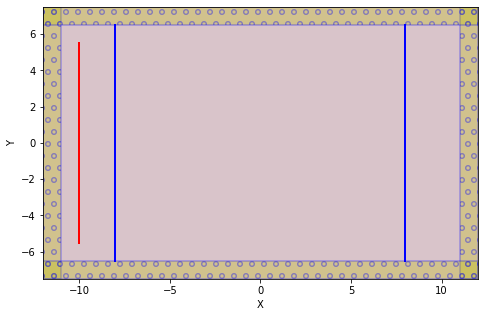

In [291]:
#Background material
geometry = [mp.Block(mp.Vector3(mp.inf, mp.inf, mp.inf),
                     center=mp.Vector3(0,0),
                     material=mp.Medium(index=n_1))]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*2),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, 0), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, 0), size=mp.Vector3(0,mon_2_h,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

#Simulate
mp.verbosity(1)
sim.run(mp.at_every(1, animate), until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 5e-3))

animate.to_mp4(10, "Ez_norm.mp4")

In [292]:
Video("Ez_norm.mp4")

In [293]:

#Get Fourier-transformed fields of incident pulse
norm_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
norm_inc_flux = mp.get_fluxes(incident)

flux_freqs = mp.get_flux_freqs(tran)

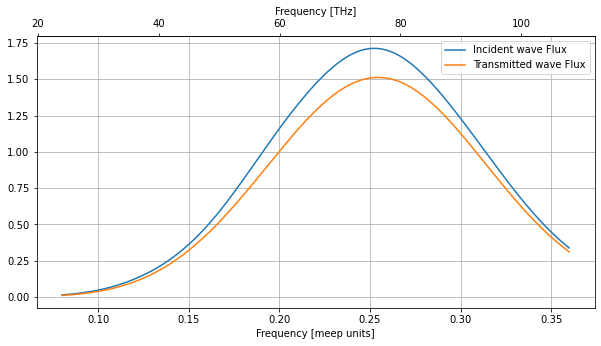

In [294]:
plt.plot(flux_freqs, norm_inc_flux, label="Incident wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

In [295]:
sim.reset_meep()

# Actual Run

In [296]:
#define geometry

#Background material
geometry = [mp.Block(mp.Vector3(mp.inf, mp.inf, mp.inf),
                     center=mp.Vector3(0,0),
                     material=mp.Medium(index=n_1))]

#Layers Material
for ii in range(N_layers):
    geometry.append(mp.Block(mp.Vector3(width_2, mp.inf, mp.inf),
                     center=mp.Vector3(ii*(width_1+width_2) -bragg_width/2 + width_1 + width_2/2, 0),
                     material=mp.Medium(index=n_2)))
    
#define sources
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*2),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, 0),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]


#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)


In [297]:
##Flux Monitors Definition

#First instantiate a flux region object by telling its geometric parameters
#Then call add_flux on simulation object, passing the fluxregion as parameter. Returns flux object

#This tells meep to perform the following:
#For each of the chosen frequencies, and for each of the fields components,
#accumulate the discrete fourier transform until the end of the simulation

#Desired frequencies are in (fcen-df/2, fcen+df/2)

# Flux Monitor 1
refl_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, 0), size=mp.Vector3(0,mon_1_width,0))
refl = sim.add_flux(f_mon_central, df_mon, N_freq, refl_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, 0), size=mp.Vector3(0,mon_2_h,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

In [298]:
#load normalization data
sim.load_minus_flux_data(refl, norm_incident_data)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000237942 s
Working in 2D dimensions.
Computational cell is 24 x 15 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-5.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.2225,11.2225,11.2225)
     block, center = (-4.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.2225,11.2225,11.2225)
     block, center = (-3.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.2225,11.2225,11.2225)
     block, center = (-2.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
       

field decay(t = 50.025000000000006): 0.005004524249275342 / 0.005004524249275342 = 1.0
on time step 3087 (time=77.175), 0.00129596 s/step
field decay(t = 100.05000000000001): 0.0003994606803225405 / 0.005004524249275342 = 0.07981991102958141
field decay(t = 150.07500000000002): 0.000184967649502496 / 0.005004524249275342 = 0.03696008657152164
on time step 6376 (time=159.4), 0.00121636 s/step
field decay(t = 200.10000000000002): 0.00017934680984994537 / 0.005004524249275342 = 0.03583693492461643
on time step 9837 (time=245.925), 0.00115577 s/step
field decay(t = 250.125): 9.691470332467491e-05 / 0.005004524249275342 = 0.01936541786938253
field decay(t = 300.15000000000003): 7.168246346213503e-05 / 0.005004524249275342 = 0.014323532046530633
on time step 13356 (time=333.9), 0.00113705 s/step
field decay(t = 350.175): 4.452712382850464e-05 / 0.005004524249275342 = 0.008897373978146312
field decay(t = 400.20000000000005): 2.2441607821210624e-05 / 0.005004524249275342 = 0.004484263978630972

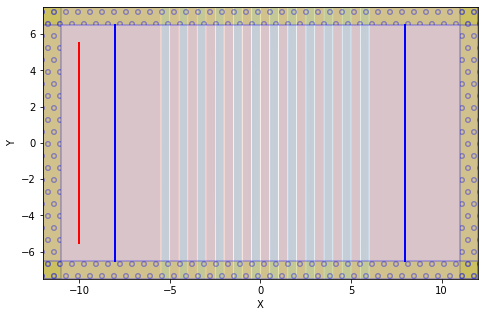

In [299]:
#Runs simulation and save animation of Ez
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})


sim.run(mp.at_every(1, animate), until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 5e-3))
        #until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

animate.to_mp4(10, "Ez_DBR.mp4")

In [300]:
Video("Ez_DBR.mp4")

In [301]:
# Get Final Fluxes
bragg_tran_flux = np.array(mp.get_fluxes(tran))
bragg_refl_flux = np.array(mp.get_fluxes(refl))*(-1)

flux_freqs = np.array(mp.get_flux_freqs(refl))

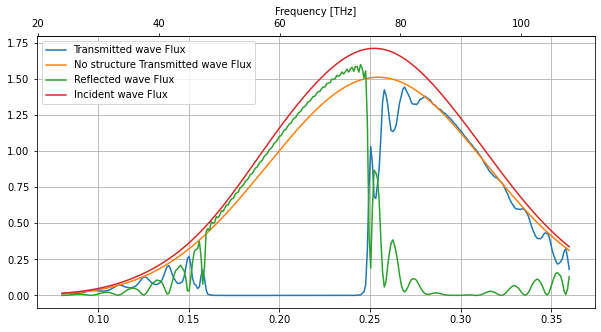

In [302]:
plt.plot(flux_freqs, bragg_tran_flux, label="Transmitted wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="No structure Transmitted wave Flux")

plt.plot(flux_freqs, bragg_refl_flux, label="Reflected wave Flux")

plt.plot(flux_freqs, norm_inc_flux, label="Incident wave Flux")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

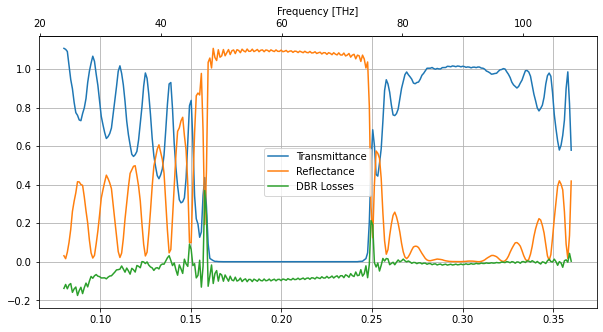

In [303]:
# Transmittance and reflectance

wvlength = 1/flux_freqs

T = bragg_tran_flux/norm_tran_flux
R = bragg_refl_flux/norm_tran_flux
Losses = 1-T-R

plt.plot(flux_freqs, T, label="Transmittance")
plt.plot(flux_freqs, R, label="Reflectance")
plt.plot(flux_freqs, Losses, label="DBR Losses")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

Dubbi: formalmente come faccio a costruire una sorgente che eccita solo alcuni modi della struttura?
Come faccio a capire quali modi eccita una sorgente arbitraria?
Come misuro aitomaticamente il bandgap?

# Notes
- Dn = +1.4, n_1 = 1.45, wm = 0.225, wmin = 0.18, wmax =0.275 Dw=0.095
- Dn = 1, n_1 = 1.45, wm = 0.255, wmin = 0.215, wmax =0.287 Dw=0.072

# Bandgap Identification

In [304]:
# Transmittance and reflectance

wvlength = 1/flux_freqs

T = bragg_tran_flux/norm_tran_flux
R = bragg_refl_flux/norm_tran_flux
Losses = 1-T-R

diff_T = np.diff(T)
diff_R = np.diff(R)
diff_Losses = np.diff(Losses)

299
299


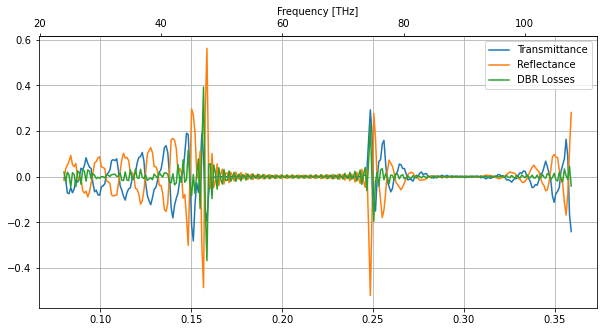

In [305]:
print(len(diff_T))
print(len(flux_freqs[:-1]))

plt.plot(flux_freqs[:-1], diff_T, label="Transmittance")
plt.plot(flux_freqs[:-1], diff_R, label="Reflectance")
plt.plot(flux_freqs[:-1], diff_Losses, label="DBR Losses")


ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')



plt.legend()
plt.grid()

In [306]:
#get maxima of drivative to get lower and upper bound of bandgap
diff_R_abs =np.abs(diff_R)
max_val = np.amax(diff_R)
max_index = np.argmax(diff_R)

peaks, _ = find_peaks(diff_R_abs, height=0.01)
print(flux_freqs[peaks])
print(flux_freqs[peaks][peaks>=max_index])

ind = np.argpartition(diff_R[peaks][peaks>=max_index], -2)[-2:]
bandgap_bounds = flux_freqs[peaks][peaks>=max_index][ind][::-1]

print(bandgap_bounds)

[0.08374582 0.08655518 0.08842809 0.09123746 0.09311037 0.09966555
 0.10715719 0.11277592 0.11464883 0.11745819 0.12214047 0.1277592
 0.13056856 0.13244147 0.13618729 0.13993311 0.14367893 0.14555184
 0.1483612  0.15023411 0.1567893  0.15866221 0.16147157 0.16428094
 0.1670903  0.17083612 0.17458194 0.1773913  0.18020067 0.18394649
 0.18675585 0.22795987 0.23170569 0.23451505 0.23732441 0.24013378
 0.2438796  0.24575251 0.24856187 0.25043478 0.25511706 0.25886288
 0.26541806 0.27103679 0.27571906 0.32535117 0.33284281 0.33846154
 0.34501672 0.349699   0.35625418]
[0.15866221 0.16147157 0.16428094 0.1670903  0.17083612 0.17458194
 0.1773913  0.18020067 0.18394649 0.18675585 0.22795987 0.23170569
 0.23451505 0.23732441 0.24013378 0.2438796  0.24575251 0.24856187
 0.25043478 0.25511706 0.25886288 0.26541806 0.27103679 0.27571906
 0.32535117 0.33284281 0.33846154 0.34501672 0.349699   0.35625418]
[0.15866221 0.25043478]


In [307]:
bandgap_mean = np.mean(bandgap_bounds)
bandgap_delta = bandgap_bounds[1]-bandgap_bounds[0]
bandgap_ratio = bandgap_delta/bandgap_mean

print("Mean freqeuency: ",bandgap_mean)
print("Delta freqeuency: ",bandgap_delta)
print("Ratio Delta/mean: ",bandgap_ratio)

Mean freqeuency:  0.2045484949832776
Delta freqeuency:  0.09177257525083615
Ratio Delta/mean:  0.44865925441465027


299
299


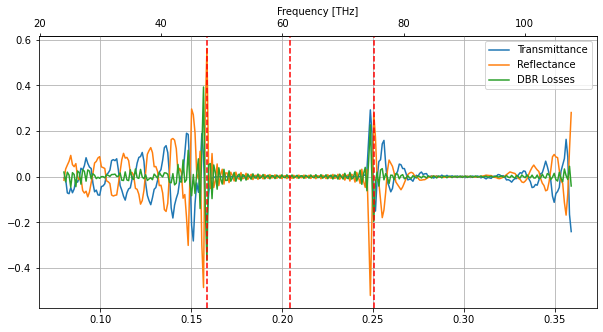

In [308]:

print(len(diff_T))
print(len(flux_freqs[:-1]))

plt.plot(flux_freqs[:-1], diff_T, label="Transmittance")
plt.plot(flux_freqs[:-1], diff_R, label="Reflectance")
plt.plot(flux_freqs[:-1], diff_Losses, label="DBR Losses")

plt.axvline(bandgap_bounds[0], color="red", linestyle="dashed")
plt.axvline(bandgap_bounds[1], color="red", linestyle="dashed")
plt.axvline(bandgap_mean, color="red", linestyle="dashed")


ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')



plt.legend()
plt.grid()